<a href="https://colab.research.google.com/github/samikhenissi/TheoretUserModeling/blob/master/MF_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization Hyperparameters Tuning using 5 folds cross validation on Movielens data 

In [ ]:
###Downloading the Data
# Downloading movielens data in case of using Colab
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip



--2020-02-17 17:32:55--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  12.1MB/s    in 0.4s    

2020-02-17 17:32:55 (12.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
#Numba
!pip3 install numba

In [ ]:
## importing required modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as m
import random
import math
from operator import mul
import numpy as np
from numba import typeof, double, int_
from numba.decorators import  jit


In [ ]:
data = pd.read_csv("ml-100k/u.data",sep='\t',names="UserId,movieID,Rating,Timestamp".split(","))


In [ ]:
data.head()

,UserId,movieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
n_users = data.UserId.unique().shape[0]
n_items = data.movieID.unique().shape[0]


In [ ]:
#Matrix Factorization

@jit(locals={'step': int_, 'e': double, 'err': double})
def matrix_factorization(R,K, nsteps, alpha, beta ): #this funcion train the MF model Using gradient decent 
  # Input:
  # R: matrix that has the ratings used in training 
  # K: Dimension of the latent space
  # nsteps = iterations
  # alpha: learning rate
  # beta: regularization parameter
  
  #Output:
  # P: latent representation of the users
  # Q: latent representation of the items
 
  P = np.random.rand(len(R),K)
  Q = np.random.rand(len(R[0]),K)
  Q = Q.T
  steps = nsteps
  N,M = R.shape
  for step in range(steps):
      #W = calc_B(P,Q.T,R)
      for i in range(N):
          for j in range(M):
              if R[i][j] > 0:
                  eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                  for k in range(K):
                      P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                      Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j] )
  return P, Q.T

In [ ]:
@jit(locals={'step': int_, 'e': double, 'err': double})
def calculate_training_error(train_data_matrix,P,Q,beta):
  # Input: 
  # train_data_matrix: matrix that has the ratings used in training
  # P: Latent feature representation of the users
  # Q: Latent feature representation of the items
  # alpha: learning rate
  # beta: regularization parameter
  
  #Output:
  # RMSE trainging error
  
  e = 0
  count = 0
  N,M = train_data_matrix.shape
  for i in range(N):
      for j in range(M):
          if train_data_matrix[i][j] > 0:
              count = count + 1
              e = e + pow(train_data_matrix[i][j] - np.dot(P[i,:],Q.T[:,j]), 2)
              for k in range(K):
                  e = e + (beta/2) * (pow(P[i][k],2) + pow(Q.T[k][j],2)) 
  return math.sqrt(e/count)

In [ ]:
@jit(locals={'step': int_, 'e': double, 'err': double})
def calculate_testing_error(P,Q,test_data_matrix):
  # Input:
  # P: Latent feature representation of the users
  # Q: Latent feature representation of the items
  # test_data_matrix: matrix that has the ratings used for testing
  
  # Output
  # Mean Absolute Error score for the testing set
    
  e_test = 0
  num = 0
  eR = np.dot(P,Q.T)
  for i in range(len(test_data_matrix)):
      for j in range(len(test_data_matrix[0])):
          if test_data_matrix[i][j] !=0 :
              e_test = np.copy(e_test + np.abs(eR[i][j] - test_data_matrix[i][j]))
              num = num+1
  e_test = e_test / num 
  return e_test

# Cross Validation function

In [ ]:
from sklearn.model_selection import StratifiedKFold


def cross_val_MF(data,K,alpha,beta,steps,folds =5):
  # Inputs
  # data: dataframe that has the user id, movie id, rating
  # K: dimension of latent space
  # alpha: learning rate
  # beta: regularization parameter
  # steps: number of iterations
  # folds: number of K-fold to perform
  
  #Outputs
  # Average of all the training scores from a 5 steps cross validation
  # Average of all the testing scores from a 5 steps cross validation
  # list of training scores
  # list of testing (validation) scores
  
  
  kfold = StratifiedKFold(n_splits = folds, shuffle = True,  random_state = 1)
  n_splits = 0
  train_score = 0
  validation_score = 0
  train_scores = []
  test_scores = []
  for train, test in kfold.split(data,y= data['Rating']): # for each split 
    train_data, test_data = data.iloc[train], data.iloc[test]
    train_data_matrix = np.zeros((n_users, n_items))
    
    #create the training and testing matrix
    for line in train_data.itertuples():      
      train_data_matrix[line[1]-1, line[2]-1] = line[3]
      
    test_data_matrix = np.zeros((n_users, n_items))
    for line in test_data.itertuples():
        test_data_matrix[line[1]-1, line[2]-1] = line[3]

    #train the model and get P and Q    
    P,Q = matrix_factorization(train_data_matrix,K,nsteps=steps,alpha = alpha, beta = beta)
    
    #calculate training error
    e = calculate_training_error(train_data_matrix,P,Q,beta)
    train_score = train_score + e
    
    #calculate testing error
    e_test = calculate_testing_error(P,Q,test_data_matrix)
    validation_score = validation_score + e_test
    
    
    n_splits = n_splits + 1
    print("training error ",e, "test error ",e_test)
    train_scores = train_scores + [e]
    test_scores = test_scores + [e_test]
    
  print("###############################")  
  print("Final training error ",train_score/n_splits, "Final test error ",validation_score/n_splits)  
  return train_score/n_splits,validation_score/n_splits,train_scores,test_scores

# List of Hyperparameters

In [ ]:
K_list= [5,10,15,30,50,100]
alpha_list = [0.005,0.001,0.0001,0.00001]
beta_list = [0.01,0.001,0.0001,0]
steps_list = [150,300,500,1000]

#Tuning K (Latent space dimension)

In [ ]:
### we set values for alpha, beta and steps

alpha = 0.001
beta = 0.01
steps = 300

In [ ]:
train_score = []
val_score = []
for K in K_list:
  print("*********************")
  print("For K = ",K)
  print("*********************")
  train_error,val_error,_,_ = cross_val_MF(data,K,alpha,beta,steps)
  train_score = train_score + [train_error]
  val_score = val_score + [val_error]

*********************
For K =  5
*********************


<ipython-input-12-7a7ee7cff15f>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculate_testing_error" failed type inference due to: Invalid use of Function(<function copy at 0x7ff4bb5012f0>) with argument(s) of type(s): (float64)
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function copy at 0x7ff4bb5012f0>)
[2] During: typing of call at <ipython-input-12-7a7ee7cff15f> (17)


File "<ipython-input-12-7a7ee7cff15f>", line 17:
def calculate_testing_error(P,Q,test_data_matrix):
    <source elided>
          if test_data_matrix[i][j] !=0 :
              e_test = np.copy(e_test + np.abs(eR[i][j] - test_data_matrix[i][j]))
              ^

  @jit(locals={'step': int_, 'e': double, 'err': double})


training error  0.815498290481875 test error  0.7451684342876771
training error  0.814471646553765 test error  0.748036342068056
training error  0.814699705437257 test error  0.7418203630438643
training error  0.8151370080621101 test error  0.7421044633962512
training error  0.8117647878974963 test error  0.7379548221748274
###############################
Final training error  0.8143142876865006 Final test error  0.7430168849941352
*********************
For K =  10
*********************
training error  0.7118235892171936 test error  0.7847987793753056
training error  0.7128711778828063 test error  0.7882134698129389
training error  0.711661199552672 test error  0.784572050449053
training error  0.7138511067140721 test error  0.7862705176826714
training error  0.7108453171249102 test error  0.7880833797975172
###############################
Final training error  0.7122104780983308 Final test error  0.7863876394234972
*********************
For K =  15
*********************
training error

Text(0, 0.5, 'score')

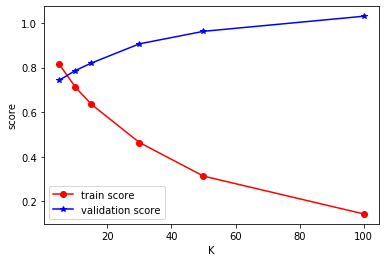

In [ ]:
import matplotlib.pyplot as plt

plt.plot(K_list,train_score,'o-',color='r',label='train score')
plt.plot(K_list,val_score,'*-',color='b',label = 'validation score')
plt.legend()
plt.xlabel("K")
plt.ylabel("score")


#Tuning the learning rate

In [ ]:
K = 10
beta = 0.01
steps = 300

In [ ]:
train_score = []
val_score = []
for alpha in alpha_list:
  print("*********************")
  print("For alpha = ",alpha)
  print("*********************")
  train_error,val_error,_,_ = cross_val_MF(data,K,alpha,beta,steps)
  train_score = train_score + [train_error]
  val_score = val_score + [val_error]

*********************
For alpha =  0.005
*********************
training error  0.6953552129704257 test error  0.83875345388035
training error  0.701017890715865 test error  0.8562551269377123
training error  0.6990259161674423 test error  0.8459561364379775
training error  0.7007235411813122 test error  0.8394842649302254
training error  0.7005580959927639 test error  0.843264379134155
###############################
Final training error  0.6993361314055618 Final test error  0.8447426722640842
*********************
For alpha =  0.001
*********************
training error  0.7152039367027385 test error  0.7776521400865625
training error  0.7108567116078401 test error  0.7871603015884326
training error  0.7132516101577089 test error  0.7786155222887732
training error  0.7140883069140336 test error  0.7873687778432731
training error  0.712373847470505 test error  0.7777435858075287
###############################
Final training error  0.7131548825705651 Final test error  0.781708065522914


Text(0, 0.5, 'score')

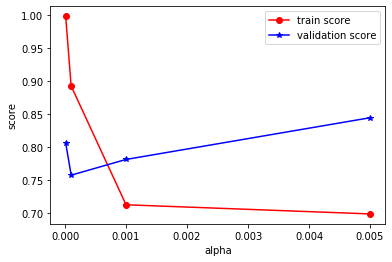

In [ ]:
plt.plot(alpha_list,train_score,'o-',color='r',label='train score')
plt.plot(alpha_list,val_score,'*-',color='b',label = 'validation score')
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score")

# Tuning the beta parameter

In [ ]:
K = 10
alpha = 0.0001
steps = 300

In [ ]:
train_score = []
val_score = []
for beta in beta_list:
  print("*********************")
  print("For beta = ",beta)
  print("*********************")
  train_error,val_error,_,_ = cross_val_MF(data,K,alpha,beta,steps)
  train_score = train_score + [train_error]
  val_score = val_score + [val_error]

*********************
For beta =  0.01
*********************
training error  0.890751996173668 test error  0.7570893564293704
training error  0.8932165035004431 test error  0.7573650747192444
training error  0.8926856797180412 test error  0.760300685570502
training error  0.8927629705810284 test error  0.7580216140230241
training error  0.892069338969295 test error  0.758635278245016
###############################
Final training error  0.8922972977884951 Final test error  0.7582824017974314
*********************
For beta =  0.001
*********************
training error  0.8821519073430284 test error  0.7591426714716063
training error  0.8827514276773277 test error  0.75902611334775
training error  0.8822736077145109 test error  0.7588128790467785
training error  0.8816956473288368 test error  0.758584201470961
training error  0.8810643893846843 test error  0.7619888558277869
###############################
Final training error  0.8819873958896777 Final test error  0.7595109442329765
****

Text(0, 0.5, 'score')

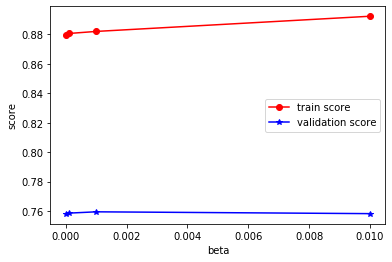

In [ ]:
plt.plot(beta_list,train_score,'o-',color='r',label='train score')
plt.plot(beta_list,val_score,'*-',color='b',label = 'validation score')
plt.legend()
plt.xlabel("beta")
plt.ylabel("score")

#Tuning the number of iterations

In [ ]:
K = 10
alpha = 0.0001
beta= 0.01


In [ ]:
train_score = []
val_score = []
for steps in steps_list:
  print("*********************")
  print("For steps = ",steps)
  print("*********************")
  train_error,val_error,_,_ = cross_val_MF(data,K,alpha,beta,steps)
  train_score = train_score + [train_error]
  val_score = val_score + [val_error]

*********************
For steps =  150
*********************
training error  0.9185851120291278 test error  0.7597213180064686
training error  0.9206383216746494 test error  0.762557597686802
training error  0.9197678780184367 test error  0.7604708896528684
training error  0.920775389032381 test error  0.7583559060269773
training error  0.9183175511127107 test error  0.7638866369685803
###############################
Final training error  0.9196168503734612 Final test error  0.7609984696683394
*********************
For steps =  300
*********************
training error  0.8934127747746041 test error  0.7603052662197051
training error  0.8945571888451612 test error  0.7587557917500123
training error  0.8931427621434408 test error  0.7577489419250706
training error  0.8913313428388941 test error  0.755884374748486
training error  0.8921239944177171 test error  0.7603147955054961
###############################
Final training error  0.8929136126039635 Final test error  0.758601834029754
**

Text(0, 0.5, 'score')

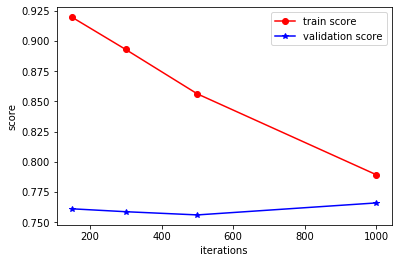

In [ ]:
plt.plot(steps_list,train_score,'o-',color='r',label='train score')
plt.plot(steps_list,val_score,'*-',color='b',label = 'validation score')
plt.legend()
plt.xlabel("iterations")
plt.ylabel("score")

#Statistical Significance

This function provides a statistical significance between the results of two models. To test if model 1 is better than model 2, we can compare the statistical significance of the difference between the mean of their 5 cross validation results. Statistically significant results can confirm that model 1 is better.

Let's consider 


model 1: MF with K = 10

model 2: MF with K = 50

In [ ]:
alpha = 0.0001
beta= 0.01
steps = 300


In [ ]:
# model 1:
K  = 10
print("*********************")
print("For K = ",K)
print("*********************")
train_error,val_error,train_scores_1,test_scores_1 = cross_val_MF(data,K,alpha,beta,steps)

*********************
For K =  10
*********************
training error  0.8926909941406633 test error  0.7554501283719733
training error  0.8953086093710831 test error  0.7597536025990718
training error  0.894286463408843 test error  0.7563686768287297
training error  0.8944888714250091 test error  0.7557569953549075
training error  0.8902136492131386 test error  0.7592562588643003
###############################
Final training error  0.8933977175117475 Final test error  0.7573171324037965


In [ ]:
# model 2
K  = 50
print("*********************")
print("For K = ",K)
print("*********************")
train_error,val_error,train_scores_2,test_scores_2 = cross_val_MF(data,K,alpha,beta,steps) 


*********************
For K =  50
*********************
training error  0.7572368930942444 test error  0.8400108258690072
training error  0.7603365540897663 test error  0.8396825103361343
training error  0.7626975968018497 test error  0.8413921237649369
training error  0.7585735577075386 test error  0.8355183016402954
training error  0.7547661801661449 test error  0.8404964189320197
###############################
Final training error  0.7587221563719087 Final test error  0.8394200361084787


We are interested in comparing **test_scores_1** and **test_scores_2** that corresponds to the testing score from model 1 and model 2.

In [ ]:
from scipy import stats
t,p = stats.ttest_rel(test_scores_1,test_scores_2)
print("p-value is",p)
print("t statistic is",t)

p-value is 2.1478614473496927e-07
t statistic is -72.67737965260861


As we can see, the p-value is below 0.05. We can say that the accuracy of model with 10 neighbors is significantly different from MF with 50 neighbors